In [1]:

import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
%matplotlib inline

import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import sklearn.gaussian_process as gp
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.utils.extmath import cartesian
from sklearn.inspection._partial_dependence import _grid_from_X
from sklearn.inspection._partial_dependence import _partial_dependence_recursion
from sklearn.inspection._partial_dependence import _partial_dependence_brute
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import skopt
from skopt.learning import ExtraTreesRegressor as opt_ETR
from skopt.learning import RandomForestRegressor as opt_RFR

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import norm

import shap

import sys, os
sys.dont_write_bytecode = True

import pickle
import itertools

import conditions, gen_data, analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Figures'
os.makedirs(PATH, exist_ok = True)

In [2]:
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'Hiragino sans'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams.update({'mathtext.default':  'regular' })

In [3]:
def arrow(start, end):
    
    point = {
        'start': start,
        'end': end
        }
    
    ax.annotate('', xy=point['end'], xytext=point['start'],
                arrowprops=dict(arrowstyle=ArrowStyle('|-|', widthA=0.35, widthB=0.35),
                                connectionstyle='arc3',
                                facecolor='gray', edgecolor='gray')
                )
    
    #plt.xlim(0,9)
    #plt.ylim(0,10)
    

def corrdot(*args, **kwargs):
    """
    from https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
    """
    corr_r = args[0].corr(args[1], "pearson")
    #corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter(
        [0.5],
        [0.5],
        marker_size,
        [corr_r],
        alpha=0.6,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        transform=ax.transAxes,
    )
    font_size = 18
    ax.annotate(
        corr_text,
        [
            0.5,
            0.5,
        ],
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize=font_size,
    )

In [4]:
condition = conditions.calc_condition()
Reaction = condition['Reaction']
data_sheet = condition['data_sheet_name']
converted = analysis.analysis_data_convert(condition, data_sheet, use_models=[], idx=None)
feat, target = converted['feat'], converted['target']
feat.columns

20220318 rwgs_250 all data


Index(['Group', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density', 'BG_Oxide',
       'Ox Num_Oxide', 'Eads_CO2'],
      dtype='object')

In [5]:
print('-' * 80)
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
pgm_num, add_num, supp_num, CalT_num = condition['pgm_num'], condition['add_num'], condition['supp_num'], condition['CalT_num']

feat, target = converted['feat'], converted['target']
cur_max = target.max()
cur_min = target.min()

model  = ExtraTreesRegressor(n_estimators = 100, random_state = 1107, n_jobs = -1)
cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
analysis.crossvalid(feat, target, model, cvf)
print('-' * 80)

--------------------------------------------------------------------------------
Train ... RMSE: 0.007, MSE: 0.000, MAE: 0.001, R2: 1.000, RMSE detail (sd: 0.005, min:0.000, max:0.011)
Test ... RMSE: 0.399, MSE: 0.160, MAE: 0.326, R2: 0.812, RMSE detail (sd: 0.033, min:0.312, max:0.468)
--------------------------------------------------------------------------------


In [6]:
desc = converted['desc']
desc_cols = conditions.desc_columns(Reaction)
basic_desc = desc_cols['basic_desc_columns']

pgm_plus_ReAu = desc_cols['pgm_plus_ReAu']
noble_gas = desc_cols['noble_gas']
drop_elems = desc_cols['drop_elems']
all_drop_elems = pgm_plus_ReAu + noble_gas + drop_elems

desc = desc[basic_desc]
desc.columns

Index(['AN', 'Group', 'Period', 'AW', 'Atom rad', 'Ion rad', 'Coval rad',
       'vdW rad', 'Crys rad', 'EN_Allred', 'EN_Pauling', 'EN_Mulliken',
       'EN_Allen', 'EN_M&B', 'EN_T&O', 'm.p.', 'b.p.', 'd_fus_H', 'Density',
       'a x 106 ', 'Heat cap', 'Therm Cond', 'Ion E', 'EA', 'VE', 'Surf E',
       'd_H_des_homo', 'd_H_des_hetero', 'FMM M', 'E_form_M', 'BG_M', 'WF_M',
       'Eads_CO2', 'OCO_angle', 'Eads_O-atom', 'Eads_C-atom', 'Eads_N2O',
       'NNO_angle', 'Eads_N-atom', 'MW_Ox', 'Ox Num_Oxide', 'FMM_Ox',
       'E_form_Ox', 'Density_Ox', 'BG_Oxide', 'Surf E Ox', 'WF_Ox',
       'Ox Num_Precursor', 'Valency'],
      dtype='object')

In [7]:
desc_cand_list = [
    'Group', 'EN_Allred', 'm.p.',
    'd_fus_H', 'Density', 'Eads_CO2',
    'BG_Oxide', 'Ox Num_Oxide'
    ]

desc = desc[desc_cand_list]
desc = desc.drop(all_drop_elems)
desc.to_csv(f'{PATH}/desc_cand.csv')
desc.columns


Index(['Group', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density', 'Eads_CO2',
       'BG_Oxide', 'Ox Num_Oxide'],
      dtype='object')

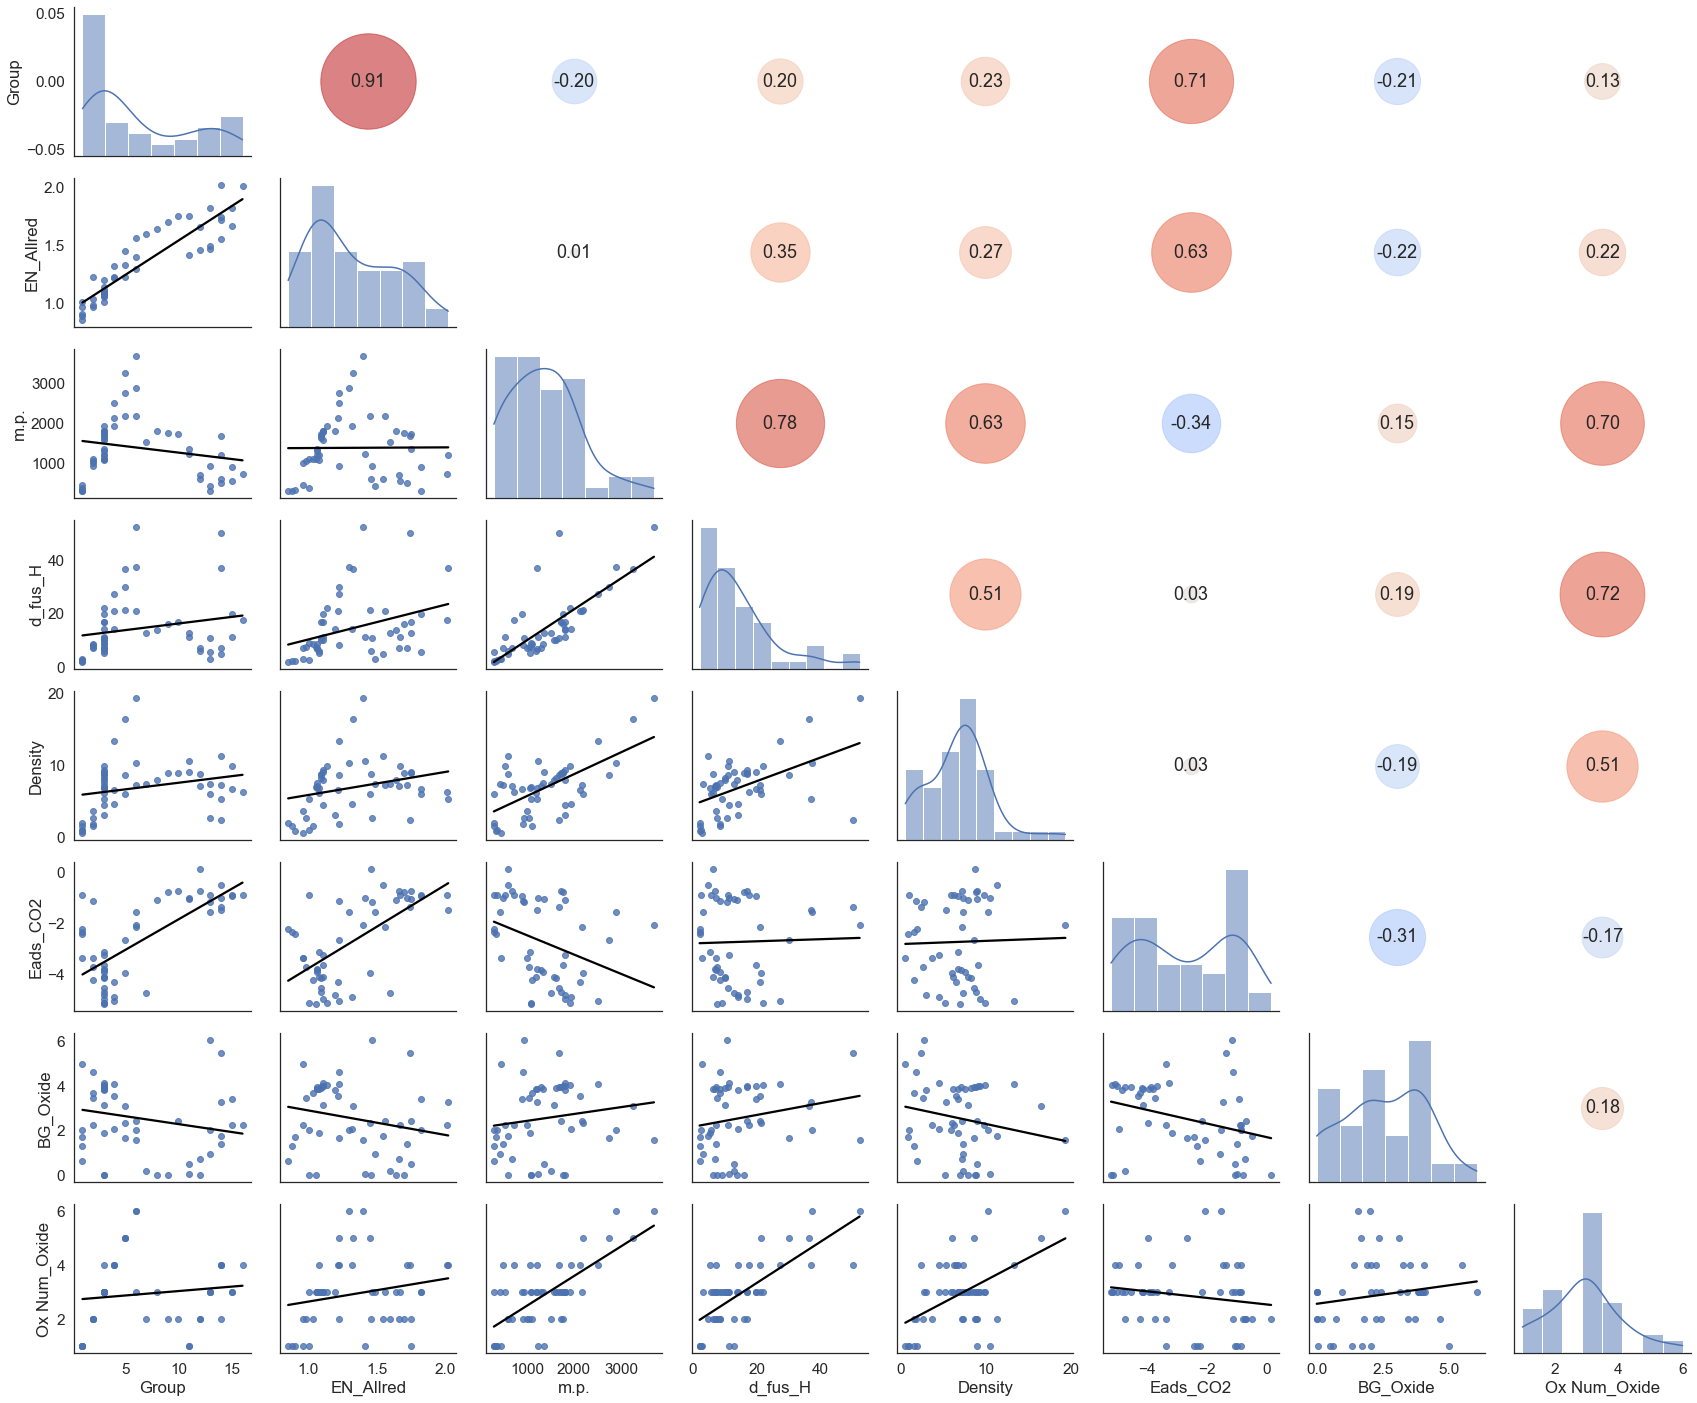

In [8]:
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.set(style="white", font_scale=1.4)
corr_desc = sns.PairGrid(desc, aspect=1.2, diag_sharey=False)
#corr_desc.map_lower(sns.regplot, lowess=True, ci=False, line_kws={"color": "black"})
corr_desc.map_lower(sns.regplot, lowess=False, ci=False, fit_reg=True, line_kws={"color": "black"})
corr_desc.map_diag(sns.histplot, kde=True)
corr_desc.map_upper(corrdot)
corr_desc.savefig(f'{PATH}/descriptors_correplot_v4.png', bbox_inches="tight", dpi=600)

In [7]:
%%time
model, error = analysis.grid_search(feat, target, use_model='ETR')

ETR
Train ... RMSE: 0.013, MSE: 0.000, MAE: 0.001, R2: 1.000, RMSE detail (sd: 0.006, min:0.000, max:0.018)
Test ... RMSE: 0.395, MSE: 0.157, MAE: 0.320, R2: 0.816, RMSE detail (sd: 0.032, min:0.321, max:0.463)
best_params: 100
CPU times: user 1min 22s, sys: 2.02 s, total: 1min 24s
Wall time: 10min 40s


In [21]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']

pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
feat, target = converted['feat'], converted['target']
feat_cols = feat.columns
model  = ExtraTreesRegressor(n_estimators = 100, random_state = 1107, n_jobs = -1)
model.fit(feat, target)

20220311 rwgs_250 all data


ExtraTreesRegressor(n_jobs=-1, random_state=1107)

SHAP_summary_plot ETR prop222 was finished.


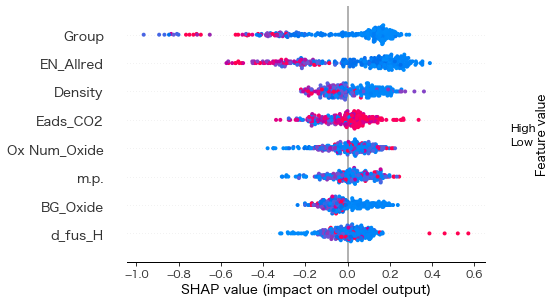

In [22]:
analysis.shap_summary_plot(condition, model, feat, target, save=True)

10-fold One-shot plot ETR prop222 was finished.


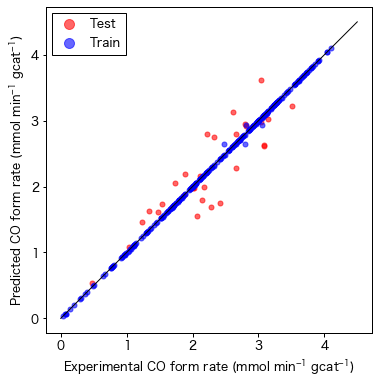

In [18]:
analysis.one_shot_plot(condition, feat, target, model, Reaction, test_size=0.1, random_state=1107, save=True)

Feature_importance plot ETR prop222 was finished.


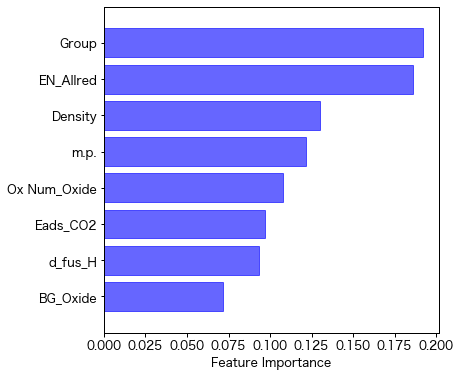

In [8]:
analysis.plot_importance(condition, model, labels=feat_cols, topk=20, save=True)

LeaveOneOut plot ETR prop222 was finished.


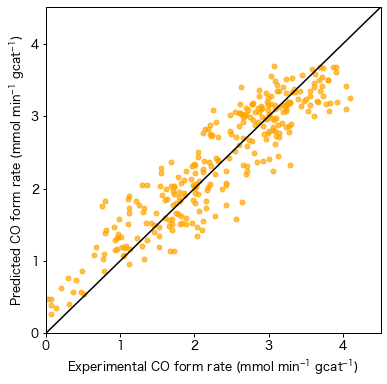

In [19]:
analysis.loo_plot(condition, feat, target, feat_cols, model, plot_texts=False, save=True)

20220318 rwgs_250 all data
No. 1
Mo 10.0 H 0.0 H 0.0 H 0.0 H 0.0
CO form rate (mmol min-1 gcat-1): 2.55
No. 2
V 10.0 H 0.0 H 0.0 H 0.0 H 0.0
CO form rate (mmol min-1 gcat-1): 2.06
No. 3
Ce 10.0 H 0.0 H 0.0 H 0.0 H 0.0
CO form rate (mmol min-1 gcat-1): 2.04


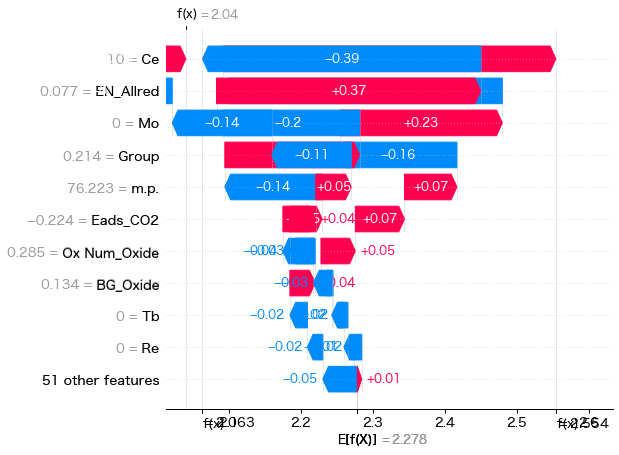

In [6]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']

pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[], idx=None)
data = converted['data']
feat, target = converted['feat'], converted['target']
target_name = condition['target_name']
feat_cols = feat.columns
model  = ExtraTreesRegressor(n_estimators = 100, random_state = 1107, n_jobs = -1)
model.fit(feat, target)

#explainer = shap.TreeExplainer(model, feat)
#shap_values = explainer.shap_values(feat)

explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)

for i in range(3):
    print('No.', data['No.'][i])
    print(
        data['Ad1'][i],data['Ad1_wt%'][i],data['Ad2'][i],data['Ad2_wt%'][i],data['Ad3'][i],data['Ad3_wt%'][i],
        data['Ad4'][i],data['Ad4_wt%'][i],data['Ad5'][i],data['Ad5_wt%'][i]
        )
    print('CO form rate (mmol min-1 gcat-1):', round(data[target_name][i], 2))
    shap.plots.waterfall(shap_values[i], max_display=11)

No. 180
Al 0.2 Mo 0.8 Cs 1.0 Ba 1.0 H 0.0
CO form rate (mmol min-1 gcat-1): 1.8


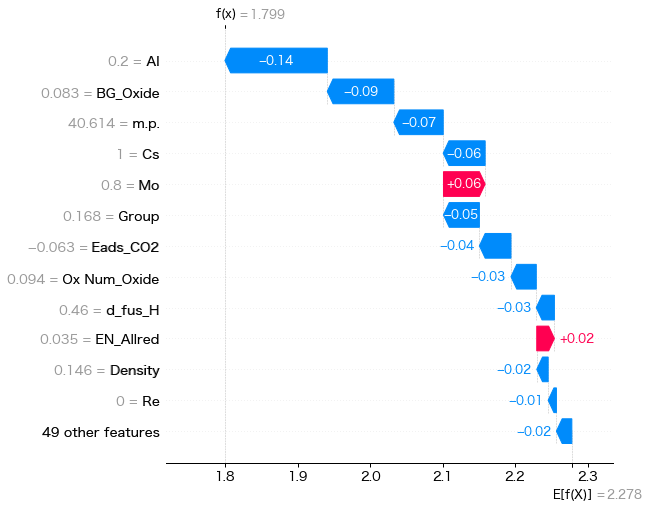

In [13]:
data = converted['data']
model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
model.fit(feat, target)

#explainer = shap.TreeExplainer(model, feat)
#shap_values = explainer.shap_values(feat)

explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)

Cat_No = 180
print('No.', data['No.'][Cat_No-1])
print(
    data['Ad1'][Cat_No-1],data['Ad1_wt%'][Cat_No-1],data['Ad2'][Cat_No-1],data['Ad2_wt%'][Cat_No-1],data['Ad3'][Cat_No-1],data['Ad3_wt%'][Cat_No-1],
    data['Ad4'][Cat_No-1],data['Ad4_wt%'][Cat_No-1],data['Ad5'][Cat_No-1],data['Ad5_wt%'][Cat_No-1]
    )
print('CO form rate (mmol min-1 gcat-1):', round(data[target_name][Cat_No-1], 2))
shap.plots.waterfall(shap_values[Cat_No-1], max_display=13)

In [24]:
shap.initjs()
explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)
#shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=feat)
shap.force_plot(explainer.expected_value, shap_values, features = feat)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [6]:
def custom_oneway_pdp(
    target_feat, feat, target, model, expand_rate=0.1, grid_resolution=100, cmap_color='bwr',
    max_wt=10, max_target='auto', min_target='auto', max_feat='auto', min_feat='auto', plot=False, number=False
    ):

    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt' or Reaction == 'rwgs_300':
        label_name = 'CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)'

    elif Reaction == 'CH3OH':
        label_name = '$CH_{3}OH$ formation rate (mmol $g^{{-}1}$ $h^{{-}1}$)'

    elif Reaction == 'N2O':
        label_name = 'Tx for $N_{2}O$ conversion (℃)'

    elif Reaction == 'H2SCR':
        label_name = 'Tx for $N_{2}$ yield (℃)'

    elif Reaction == 'NH3SCR':
        label_name = 'Tx for NO conversion (℃)'

    elif Reaction == 'CH4':
        label_name = 'Tx for $CH_{4}$ conversion (℃)'

    elif Reaction == 'EtOH_CO2' or Reaction == 'EtOH_CO':
        label_name = 'Tx for EtOH conversion (℃)'

    varname = feat.columns[target_feat]
    if varname in list(desc.index):
        xu, xl = max_wt, 0
    else:
        xu = feat[varname].max()
        xl = feat[varname].min()
    
    w = expand_rate * (xu-xl)
    xaxis = np.linspace(xl-w, xu+w, num=grid_resolution, endpoint=True)
    values = [xaxis]
    grid = cartesian(values)
    
    averaged_predictions = _partial_dependence_brute(model, grid, [target_feat], feat, 'auto')
    avg_preds = averaged_predictions[1].reshape(-1, *[val.shape[0] for val in values])
    yvalues = avg_preds[0].ravel()
    
    if min_target == "auto":
        rng_min = min(yvalues.min(), np.array(target).min())
    else:
        rng_min = min_target
    if max_target == "auto":
        rng_max = max(yvalues.max(), np.array(target).max())
    else:
        rng_max = max_target
    fig, ax = plt.subplots(facecolor='white', figsize = (8,8))
        
    wd = rng_max-rng_min
    ax.plot(values[0], yvalues, color='black', linewidth=2)
    
    divider = make_axes_locatable(ax)
    ax_x = divider.append_axes("top", 1.0, pad=0.1, sharex=ax)
    ax.set_ylim(rng_min-expand_rate*wd, rng_max+expand_rate*wd)
    
    if (max_feat =="auto") & (min_feat == "auto"):
        ax.set_xlim(xl-w*(1+expand_rate), xu + w*(1+ expand_rate))
    elif min_feat == "auto":
        ax.set_xlim(xl-w*(1+expand_rate), max_feat)
    elif max_feat == "auto":
        ax.set_xlim(min_feat, xu + w*(1+ expand_rate))
    elif varname in list(desc.index):
        ax.set_xlim(0, max_wt)
    else:
        ax.set_xlim(min_feat, max_feat)
    
    if varname in list(desc.index):
        ax.set_xlabel(f'{varname} (wt%)', fontsize=14)
    else:
        ax.set_xlabel(varname, fontsize=14)
    
    ax.set_ylabel(label_name, fontsize=14)
    ax_x.hist(feat[varname], bins=grid_resolution, color='0.7')
    ax_x.set_ylabel('datapoints', fontsize=11)
    ax_x.xaxis.set_tick_params(labelbottom=False)
    
    if plot:
        cs = ax.scatter(feat[varname], target, c=np.array(target), cmap=cmap_color, s=7, alpha=0.8)
        fig.colorbar(cs, ax=ax, fraction=.1, alpha=0.8, cmap=cmap_color)
    if number:
        for i, txt in enumerate(feat.index):
            ax.annotate(txt, (feat[varname][i], target[i]), ha='center', va='center', fontsize=7)

def custom_twoway_pdp(
    target_feat1, target_feat2, feat, target, model,
    grid_resolution, line_color='black', cmap_color='bwr', contourf_color='viridis',
    scatter=False, hist=False, x_lim="auto", y_lim="auto"
    ):
    
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt' or Reaction == 'rwgs_300':
        label_name = 'CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)'
    
    elif Reaction == 'CH3OH':
        label_name = '$CH_{3}OH$ formation rate (mmol $g^{{-}1}$ $h^{{-}1}$)'
    
    elif Reaction == 'N2O':
        label_name = 'Tx for $N_{2}O$ conversion (℃)'

    elif Reaction == 'H2SCR':
        label_name = 'Tx for $N_{2}$ yield (℃)'

    elif Reaction == 'NH3SCR':
        label_name = 'Tx for NO conversion (℃)'

    elif Reaction == 'CH4':
        label_name = 'Tx for $CH_{4}$ conversion (℃)'

    elif Reaction == 'EtOH_CO2' or Reaction == 'EtOH_CO':
        label_name = 'Tx for EtOH conversion (℃)'

    pair_index = [target_feat1, target_feat2]
    varnames = feat.columns[pair_index]

    xl0, xu0 = feat[varnames[0]].min(), feat[varnames[0]].max()
    xl1, xu1 = feat[varnames[1]].min(), feat[varnames[1]].max()

    w0 = 0.1*(xu0-xl0)
    w1 = 0.1*(xu1-xl1)

    xaxis = np.linspace(xl0-w0, xu0+w0, num=grid_resolution, endpoint=True)
    yaxis = np.linspace(xl1-w1, xu1+w1, num=grid_resolution, endpoint=True)

    values = [xaxis, yaxis]
    grid = cartesian(values)
    features_indices = list(pair_index)

    averaged_predictions = _partial_dependence_brute(model, grid, features_indices, feat, 'auto')

    avg_preds = averaged_predictions[1].reshape(-1, *[val.shape[0] for val in values])

    XX, YY = np.meshgrid(values[0], values[1])
    Z = avg_preds[0].T
    Z_level = np.linspace(avg_preds[0].min(), avg_preds[0].max(), num=12)

    fig, ax_main = plt.subplots(facecolor='white', figsize=(8, 8.5))

    CS = ax_main.contour(XX, YY, Z, levels=Z_level, linewidths=0.5, zorder=2, colors=line_color)
    CS_f = ax_main.contourf(XX, YY, Z, levels=Z_level, vmax=Z_level[-1], vmin=Z_level[0], zorder=1, alpha=0.4, cmap=contourf_color)
    ax_main.clabel(CS, fmt='%2.2f', colors=line_color, zorder=2, fontsize=9, inline=True)
    
    if scatter:
        cs2 = ax_main.scatter(feat[varnames[0]], feat[varnames[1]],
                              c=np.array(target), cmap=cmap_color, s=20, zorder=3, alpha=1)
    if hist:
        divider = make_axes_locatable(ax_main)
        ax_x = divider.append_axes("top", 1.0, pad=0.1, sharex=ax_main)
        ax_y = divider.append_axes("right", 1.0, pad=0.1, sharey=ax_main)
        
        ax_x.xaxis.set_tick_params(labelbottom=False)
        ax_y.yaxis.set_tick_params(labelleft=False)
        ax_x.hist(feat[varnames[0]], bins=grid_resolution, color='0.7')
        ax_x.set_ylabel('datapoints', fontsize=11)
        ax_y.hist(feat[varnames[1]], bins=grid_resolution, orientation='horizontal', color='0.7')
        ax_y.set_xlabel('datapoints', fontsize=11)
        

    ax_main.set_xlabel(varnames[0], fontsize=14)
    ax_main.set_ylabel(varnames[1], fontsize=14)
    
    if scatter:
        #plt.colorbar(aspect=20)
        fig.colorbar(CS_f, ax=ax_main, orientation='horizontal', fraction=.1, alpha=0.8, extend='both', aspect=50, pad=0.1, ticks=list(np.arange(round(Z.min()-0.1, 1), round(Z.max()+0.1, 1), 0.2))).set_label(f'Predicted {label_name}', fontsize=14)
        fig.colorbar(cs2, ax=ax_main, orientation='vertical', fraction=.1, alpha=0.8, aspect=50).set_label(f'Experimental {label_name}', fontsize=14)
        
    ax_main.set_xlim([xl0-w0, xu0+w0])
    ax_main.set_ylim([xl1-w1, xu1+w1])
    
    if x_lim != "auto":
        ax_main.set_xlim(x_lim)
        
    if y_lim != "auto":
        ax_main.set_ylim(y_lim)

In [51]:
desc_cand_list = ['Group', 'EN_Allred', 'Ox Num_Precursor', 'Density', 'Eads_CO2', 'm.p.', 'BG_Oxide', 'd_fus_H']

col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

for pdp_col2 in itertools.combinations(desc_cand_list, 2):
    print(pdp_col2[0], pdp_col2[1])
    s =list(feat.columns).index(pdp_col2[0])
    t =list(feat.columns).index(pdp_col2[1])
    custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, scatter=True, hist=True)
    plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_col2[0]}_vs_{pdp_col2[1]}.png', dpi=600, bbox_inches = 'tight')

Group EN_Allred
Group Ox Num_Precursor
Group Density
Group Eads_CO2
Group m.p.
Group BG_Oxide
Group d_fus_H
EN_Allred Ox Num_Precursor
EN_Allred Density
EN_Allred Eads_CO2
EN_Allred m.p.
EN_Allred BG_Oxide
EN_Allred d_fus_H
Ox Num_Precursor Density
Ox Num_Precursor Eads_CO2
Ox Num_Precursor m.p.
Ox Num_Precursor BG_Oxide
Ox Num_Precursor d_fus_H
Density Eads_CO2
Density m.p.
Density BG_Oxide
Density d_fus_H
Eads_CO2 m.p.
Eads_CO2 BG_Oxide
Eads_CO2 d_fus_H
m.p. BG_Oxide
m.p. d_fus_H
BG_Oxide d_fus_H


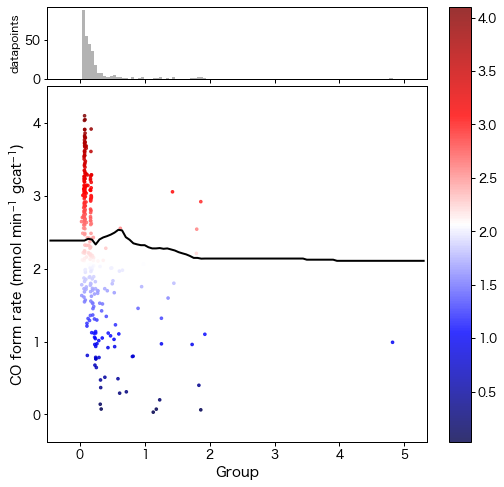

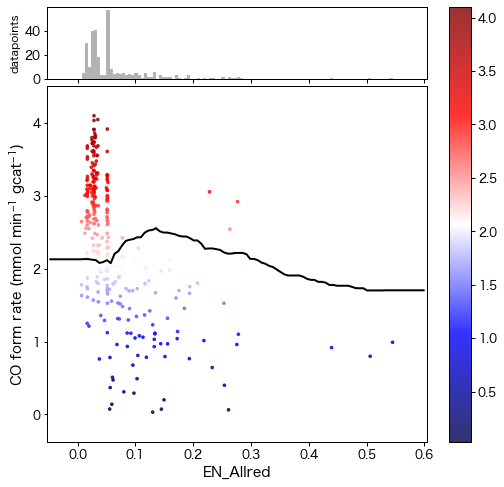

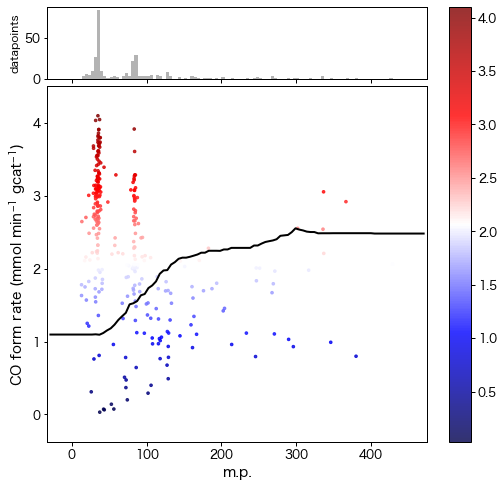

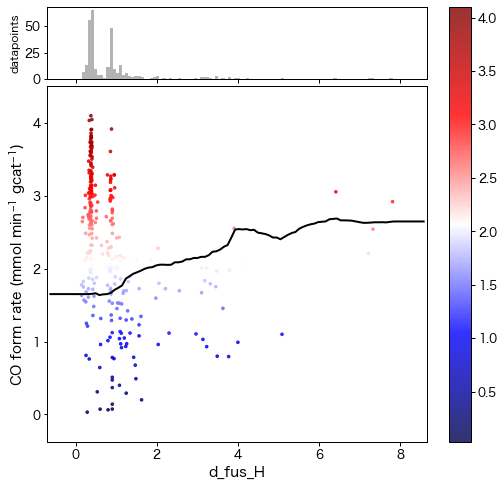

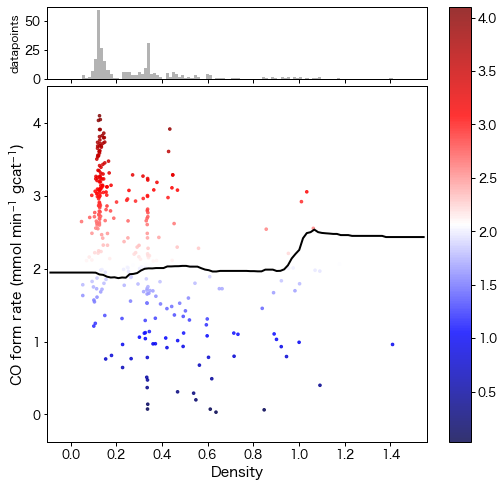

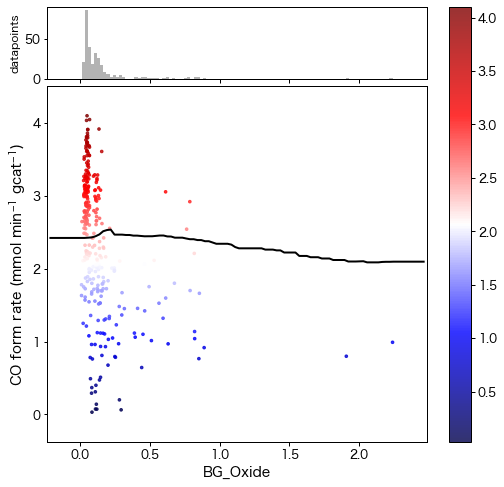

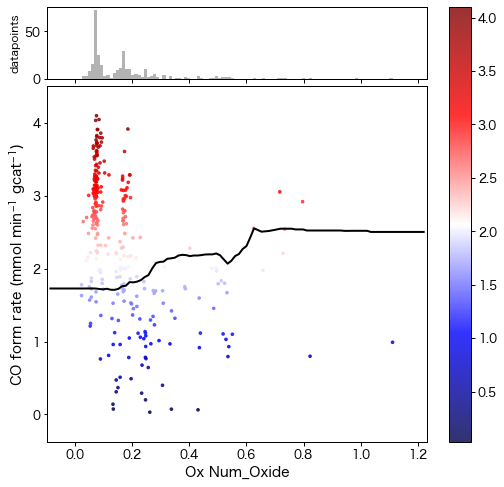

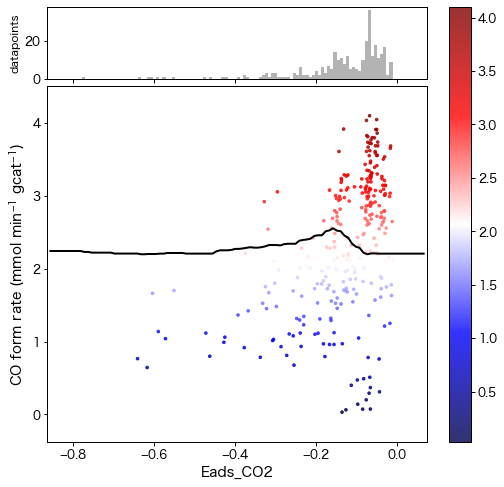

In [10]:
col_1 = '1way_PDP'
os.makedirs(f'{PATH}/{col_1}', exist_ok=True)

for i, s in enumerate(feat.columns):
    custom_oneway_pdp(
        i, feat, target, model, expand_rate=0.1, grid_resolution=100, cmap_color='seismic',
        max_wt=10, max_target='auto', min_target='auto', max_feat='auto', min_feat='auto', plot=True, number=False
        )
    plt.savefig(f'{PATH}/{col_1}/{col_1}_{s}.png', dpi=300, bbox_inches='tight')

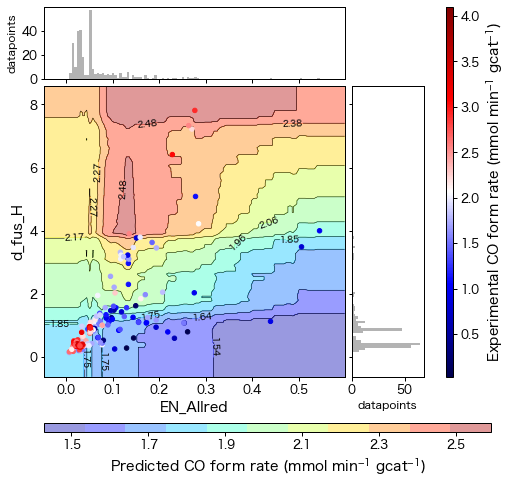

In [7]:
desc_cand_list = ['Group', 'EN_Allred', 'Ox Num_Precursor', 'Density', 'Eads_CO2', 'm.p.', 'BG_Oxide', 'd_fus_H']

pdp_cols = ['EN_Allred', 'd_fus_H']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}.png', dpi=600, bbox_inches = 'tight')

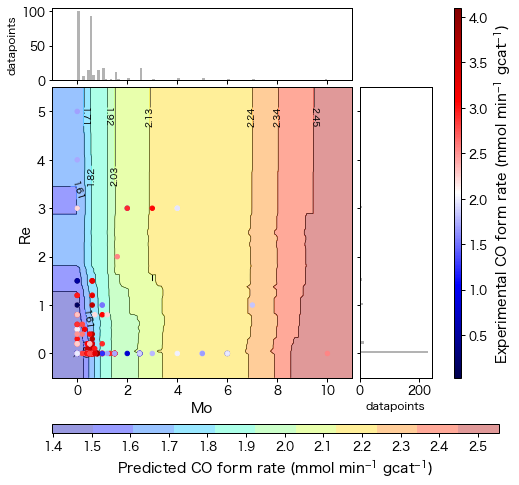

In [13]:
pdp_cols = ['Mo', 'Re']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}.png', dpi=600, bbox_inches = 'tight')

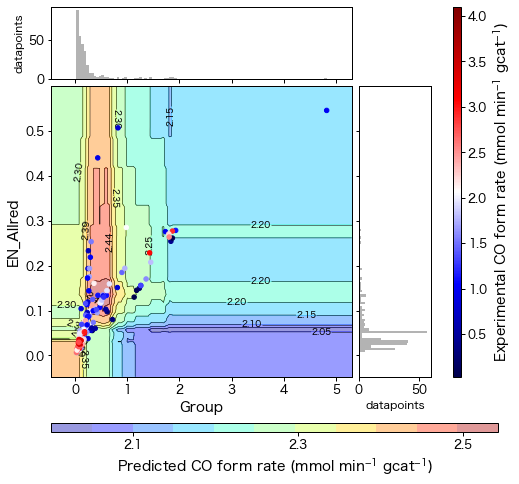

In [21]:
pdp_cols = ['Group', 'EN_Allred']
col_2 = '2way_PDP'
os.makedirs(f'{PATH}/{col_2}', exist_ok=True)

s =list(feat.columns).index(pdp_cols[0])
t =list(feat.columns).index(pdp_cols[1])

custom_twoway_pdp(s, t, feat, target, model, grid_resolution=100, line_color='black', cmap_color='seismic', contourf_color='jet', scatter=True, hist=True)
plt.savefig(f'{PATH}/{col_2}/{col_2}_{pdp_cols[0]}_vs_{pdp_cols[1]}_v2.png', dpi=600, bbox_inches = 'tight')

In [14]:
target_feat1 =list(feat.columns).index(pdp_cols[0])
target_feat2 =list(feat.columns).index(pdp_cols[1])
grid_resolution = 100

pair_index = [target_feat1, target_feat2]
varnames = feat.columns[pair_index]

xl0, xu0 = feat[varnames[0]].min(), feat[varnames[0]].max()
xl1, xu1 = feat[varnames[1]].min(), feat[varnames[1]].max()

w0 = 0.1*(xu0-xl0)
w1 = 0.1*(xu1-xl1)

xaxis = np.linspace(xl0-w0, xu0+w0, num=grid_resolution, endpoint=True)
yaxis = np.linspace(xl1-w1, xu1+w1, num=grid_resolution, endpoint=True)

values = [xaxis, yaxis]
grid = cartesian(values)
features_indices = list(pair_index)

averaged_predictions = _partial_dependence_brute(model, grid, features_indices, feat, 'auto')

avg_preds = averaged_predictions[1].reshape(-1, *[val.shape[0] for val in values])

XX, YY = np.meshgrid(values[0], values[1])
Z = avg_preds[0].T
Z_level = np.linspace(avg_preds[0].min(), avg_preds[0].max(), num=12)

In [16]:
averaged_predictions

(array([[1.98489106, 1.98489106, 1.98489106, ..., 2.45500328, 2.45500328,
         2.45500328]]),
 array([[1.39809733, 1.39809733, 1.39809733, ..., 2.4938702 , 2.4938702 ,
         2.4938702 ],
        [2.06310706, 2.06310706, 2.06310706, ..., 2.28764377, 2.28764377,
         2.28764377],
        [2.03993294, 2.03993294, 2.03993294, ..., 2.05955633, 2.05955633,
         2.05955633],
        ...,
        [2.55376474, 2.55376474, 2.55376474, ..., 2.90512777, 2.90512777,
         2.90512777],
        [2.53843973, 2.53843973, 2.53843973, ..., 3.22477849, 3.22477849,
         3.22477849],
        [2.42334473, 2.42334473, 2.42334473, ..., 2.90840276, 2.90840276,
         2.90840276]]))

In [7]:
%%time

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
date, pgm_model, add_model, supp_model = condition['date'], condition['pgm_model'], condition['add_model'], condition['supp_model']
data, add_desc, feat, target = converted['data'], converted['add_desc'], converted['feat'], converted['target']

MODEL_TYPES = [f'prop{add_model}']
errors = {}
cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
log_param1 = [1e-2, 1e-1, 1.0, 10, 1e2]
log_param2 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
log_param3 = [1.0, 10, 1e2, 1e3, 1e4, 1e5]

print('Lasso', f'prop{add_model}')
cvmodel = GridSearchCV(Lasso(),
                        param_grid = {'alpha': log_param1},
                        n_jobs = -1)
errors['Lasso'] = analysis.crossvalid(feat, target, cvmodel, cvf)

print('Ridge', f'prop{add_model}')
cvmodel = GridSearchCV(Ridge(),
                        param_grid = {'alpha': log_param1},
                        n_jobs = -1)
errors['Ridge'] = analysis.crossvalid(feat, target, cvmodel, cvf)

print('GPR', f'prop{add_model}')
kernel = gp.kernels.Matern(nu = 2.5)
cvmodel = GridSearchCV(gp.GaussianProcessRegressor(kernel = kernel,
                                                    normalize_y = True,
                                                    n_restarts_optimizer = 10,
                                                    random_state = 1107),
                        param_grid = {'alpha':log_param2},
                        n_jobs = -1)
errors['GPR'] = analysis.crossvalid(feat, target, cvmodel, cvf)

print('SVR', f'prop{add_model}')
cvmodel = GridSearchCV(SVR(kernel = 'rbf'),
                        param_grid = {'C': log_param3,
                                        'gamma':log_param2,
                                        'epsilon':log_param1},
                        n_jobs = -1)
errors['SVR'] = analysis.crossvalid(feat, target, cvmodel, cvf)

print('RFR', f'prop{add_model}')
#model = opt_RFR(n_estimators = 100, random_state = 1107, n_jobs = 4)

cvmodel = GridSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 1107),
                        param_grid = {'n_estimators':[100, 250, 500]},
                        n_jobs = -1)

errors['RFR'] = analysis.crossvalid(feat, target, cvmodel, cvf)

print('ETR', f'prop{add_model}')
#model = opt_ETR(n_estimators = 100, random_state = 1107, n_jobs = 4)

cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1107),
                        param_grid = {'n_estimators':[100, 250, 500]},
                        n_jobs = -1)

errors['ETR'] = analysis.crossvalid(feat, target, cvmodel, cvf)

"""
print('XGB', f'prop{pgm_model}{add_model}{supp_model}')
cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1107),
                        param_grid = {'n_estimators':[100, 250, 500]},
                        n_jobs = -1)
errors['XGB_{}'.format(f'prop{pgm_model}{add_model}{supp_model}')] = analysis.crossvalid(feat, target, cvmodel, cvf)
"""


20220318 rwgs_250 all data
Lasso prop1


/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e-02, tolerance: 1.829e-02
  model = cd_fast.enet_coordinate_descent(
/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.177e-02, tolerance: 1.837e-02
  model = cd_fast.enet_coordinate_descent(
/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Train ... RMSE: 0.817, MSE: 0.673, MAE: 0.657, R2: 0.233, RMSE detail (sd: 0.067, min:0.570, max:0.875)
Test ... RMSE: 0.903, MSE: 0.843, MAE: 0.696, R2: 0.034, RMSE detail (sd: 0.167, min:0.673, max:1.631)
Ridge prop1
Train ... RMSE: 0.669, MSE: 0.451, MAE: 0.534, R2: 0.486, RMSE detail (sd: 0.050, min:0.575, max:0.731)
Test ... RMSE: 0.827, MSE: 0.691, MAE: 0.633, R2: 0.201, RMSE detail (sd: 0.091, min:0.636, max:1.031)
GPR prop1


/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/shinyamine/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown 

Train ... RMSE: 0.511, MSE: 0.283, MAE: 0.398, R2: 0.677, RMSE detail (sd: 0.149, min:0.193, max:0.611)
Test ... RMSE: 0.705, MSE: 0.502, MAE: 0.539, R2: 0.423, RMSE detail (sd: 0.075, min:0.527, max:0.904)
SVR prop1
Train ... RMSE: 0.257, MSE: 0.071, MAE: 0.154, R2: 0.918, RMSE detail (sd: 0.074, min:0.126, max:0.364)
Test ... RMSE: 0.611, MSE: 0.377, MAE: 0.471, R2: 0.563, RMSE detail (sd: 0.060, min:0.449, max:0.762)
RFR prop1
Train ... RMSE: 0.157, MSE: 0.025, MAE: 0.126, R2: 0.972, RMSE detail (sd: 0.004, min:0.146, max:0.170)
Test ... RMSE: 0.425, MSE: 0.182, MAE: 0.344, R2: 0.788, RMSE detail (sd: 0.035, min:0.342, max:0.522)
ETR prop1
Train ... RMSE: 0.007, MSE: 0.000, MAE: 0.001, R2: 1.000, RMSE detail (sd: 0.005, min:0.000, max:0.011)
Test ... RMSE: 0.426, MSE: 0.183, MAE: 0.346, R2: 0.786, RMSE detail (sd: 0.036, min:0.345, max:0.506)
CPU times: user 4min 7s, sys: 39.4 s, total: 4min 47s
Wall time: 20min 34s


"\nprint('XGB', f'prop{pgm_model}{add_model}{supp_model}')\ncvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1107),\n                        param_grid = {'n_estimators':[100, 250, 500]},\n                        n_jobs = -1)\nerrors['XGB_{}'.format(f'prop{pgm_model}{add_model}{supp_model}')] = analysis.crossvalid(feat, target, cvmodel, cvf)\n"

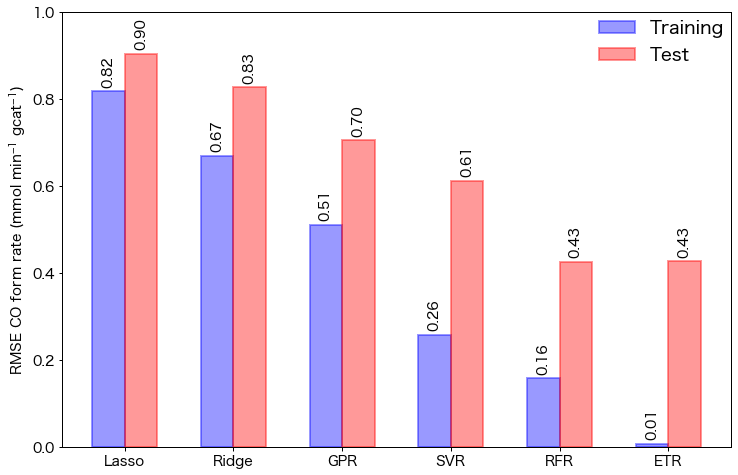

In [8]:
methods = ['Lasso', 'Ridge', 'GPR', 'SVR', 'RFR', 'ETR']
use_method = ['{}'.format(m) for m in methods ]

mean_trn = [errors[m]['trn_rmse'] for m in use_method]
mean_tes = [errors[m]['tes_rmse'] for m in use_method]

width =0.3
plt.figure(facecolor='white', figsize=(12,8))
ind = np.arange(len(methods))
plt.bar(ind, mean_trn, width, color='blue', alpha=0.4, edgecolor='blue', linewidth=2, label = 'Training')
plt.bar(ind+width, mean_tes, width, color='red', alpha=0.4, edgecolor='red', linewidth=2, label = 'Test')

for x,y in zip(ind, mean_trn):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

for x,y in zip(ind, mean_tes):
    plt.text(x+ width, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

plt.xticks(ind+(width*0.5), methods, fontsize=14)
#plt.tick_params(length=0)
plt.yticks(fontsize=14)
plt.ylabel('RMSE CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18, frameon=False)
plt.ylim(0, 1)
plt.savefig(f'{PATH}/{date}_{Reaction}_ML_methods_prop{add_model}_RMSE_v2.png', dpi=600, bbox_inches='tight')

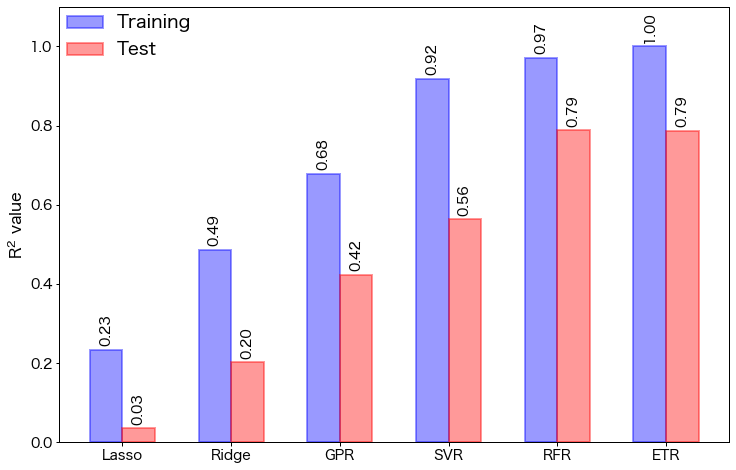

In [9]:
methods = ['Lasso', 'Ridge', 'GPR', 'SVR', 'RFR', 'ETR']
use_method = ['{}'.format(m) for m in methods ]

r2_trn = [errors[m]['trn_r2'] for m in use_method]
r2_tes = [errors[m]['tes_r2'] for m in use_method]

width =0.3
plt.figure(facecolor='white', figsize=(12,8))
ind = np.arange(len(methods))
plt.bar(ind, r2_trn, width, color='blue', alpha=0.4, edgecolor='blue', linewidth=2, label = 'Training')
plt.bar(ind+width, r2_tes, width, color='red', alpha=0.4, edgecolor='red', linewidth=2, label = 'Test')

for x,y in zip(ind, r2_trn):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

for x,y in zip(ind, r2_tes):
    plt.text(x+ width, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

plt.xticks(ind+(width*0.5), methods, fontsize=14)
#plt.tick_params(length=0)
plt.yticks(fontsize=14)
plt.ylabel('$R^{2}$ value', fontsize=16)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0, fontsize=18, frameon=False)
plt.ylim(0, 1.1)
plt.savefig(f'{PATH}/{date}_{Reaction}_ML_methods_prop{add_model}_R2_v2.png', dpi=600, bbox_inches='tight')

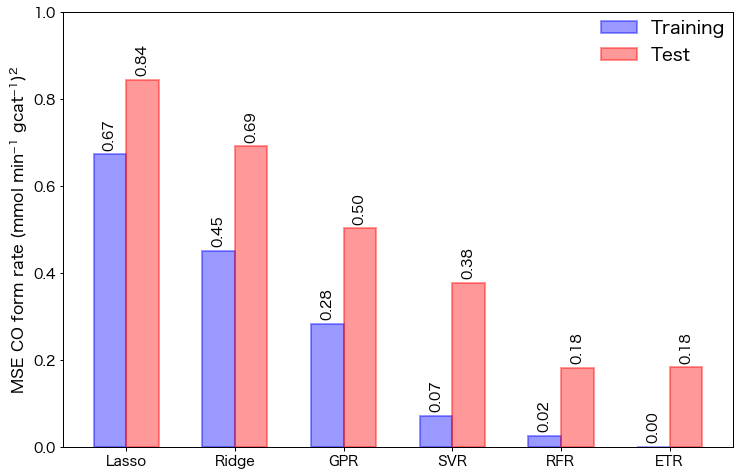

In [12]:
methods = ['Lasso', 'Ridge', 'GPR', 'SVR', 'RFR', 'ETR']
use_method = ['{}'.format(m) for m in methods ]

r2_trn = [errors[m]['trn_mse'] for m in use_method]
r2_tes = [errors[m]['tes_mse'] for m in use_method]

width = 0.3
plt.figure(facecolor='white', figsize=(12,8))
ind = np.arange(len(methods))
plt.bar(ind, r2_trn, width, color='blue', alpha=0.4, edgecolor='blue', linewidth=2, label = 'Training')
plt.bar(ind+width, r2_tes, width, color='red', alpha=0.4, edgecolor='red', linewidth=2, label = 'Test')

for x,y in zip(ind, r2_trn):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

for x,y in zip(ind, r2_tes):
    plt.text(x+ width, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

plt.xticks(ind+(width*0.5), methods, fontsize=14)
#plt.tick_params(length=0)
plt.yticks(fontsize=14)
plt.ylabel('MSE CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)$^{2}$', fontsize=16)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18, frameon=False)
plt.ylim(0, 1)
plt.savefig(f'{PATH}/{date}_{Reaction}_ML_methods_prop{add_model}_MSE_v2.png', dpi=600, bbox_inches='tight')

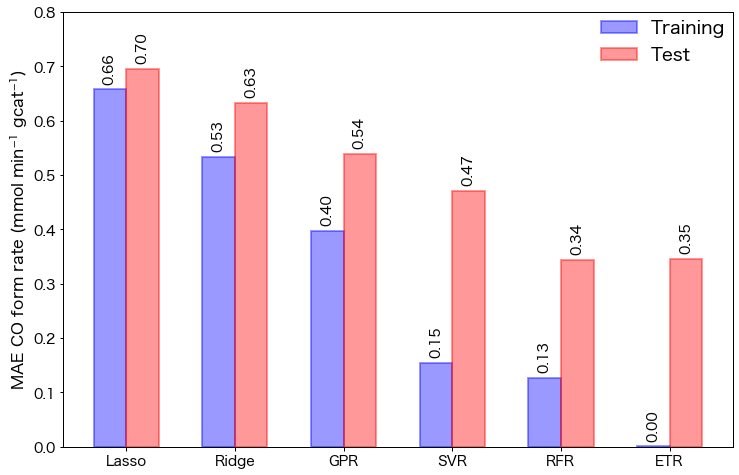

In [11]:
methods = ['Lasso', 'Ridge', 'GPR', 'SVR', 'RFR', 'ETR']
use_method = ['{}'.format(m) for m in methods ]

r2_trn = [errors[m]['trn_mae'] for m in use_method]
r2_tes = [errors[m]['tes_mae'] for m in use_method]

width = 0.3
plt.figure(facecolor='white', figsize=(12,8))
ind = np.arange(len(methods))
plt.bar(ind, r2_trn, width, color='blue', alpha=0.4, edgecolor='blue', linewidth=2, label = 'Training')
plt.bar(ind+width, r2_tes, width, color='red', alpha=0.4, edgecolor='red', linewidth=2, label = 'Test')

for x,y in zip(ind, r2_trn):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

for x,y in zip(ind, r2_tes):
    plt.text(x+ width, y+0.01, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=14)

plt.xticks(ind+(width*0.5), methods, fontsize=14)
#plt.tick_params(length=0)
plt.yticks(fontsize=14)
plt.ylabel('MAE CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=16)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18, frameon=False)
plt.ylim(0, 0.8)
plt.savefig(f'{PATH}/{date}_{Reaction}_ML_methods_prop{add_model}_MAE_v2.png', dpi=600, bbox_inches='tight')